# Merging CMU dataset with the IMDb dataset

## Motivation

Why do we want to do that? To get clean metadata.

<div class='alert-warning'> Motivate the merge. </div>

<div class='alert-warning'> We can use the cells of "relationships.ipynb". </div>

## Methods

### Naive approach

To merge the CMU dataset with the IMDb dataset, we have to have a combination of common columns that uniquely identifies a movie on both datasets. 

The easiest is to merge them on the movie title.

<div class='alert-warning'> Here we show why merging on the title is problematic. </div>

The combination of the movie title and the year can be unique.

<div class='alert-warning'> Here we show why this is also problematic. </div>

### Crawling Wikipedia and querying Wikidata

The movies in the CMU dataset are linked with the Wikipedia ID and the Freebase ID. In the IMDb dataset, they are identified by the IMDb IDs. If only there existed a mapping between Wikipedia ID / Freebase ID to IMDb IDs, the merging could be done. First, we check that these IDs can uniquely identify a movie:

<div class='alert-warning'> ... </div>

We notice that the same string also appears in the URL of the movie page on the IMDb website. With the help of an external library, [wikipedia](https://wikipedia.readthedocs.org/en/latest/), we can get the content of the Wikipedia page of a movie from its Wikipedia ID in the CMU dataset. We also notice that the IMDb page of the movie is most of the times referenced in the Wikipedia pages of the movies, meaning that we can link the two by crawling Wikipedia. However, this approach might fail if the IMDb page is not included anywhere in the Wikipedia page, or the Wikipedia page is not retrievable from its page ID.

For these cases, we follow an alternative approach. In the Wikidata page of a movie, both the Freebase ID and the IMDb ID are listed. We can use the [Wikidata Query Service](https://query.wikidata.org) to match these two together.

The `helpers.external.crawl_wikipedia` and `helpers.external.crawl_wikidata` methods are used in `helpers.external.extract_cmu_imdb_mapping` to get such mappings. The whole process takes around 24 hours but can be improved by engineering the requests sent to Wikipedia by the external library. Since we only need to do this once, we opt to focus on the other parts and stick with the implementation of the external library. `helpers.external.extract_cmu_imdb_mapping` generates such mappings by the two methods, aggregates them, and stores the final mapping (and the most complete one) in `./generated/wp2imdb.csv`. The file is available in the repository but can be regenerated simply by running this function.

```python
from helpers.external import extract_cmu_imdb_mapping
extract_cmu_imdb_mapping()
```

We use this mapping in the rest of this section to merge the two datasets.

In [1]:
import requests
import pandas as pd
from time import sleep
import wikipedia
import numpy as np

from helpers.readers import read_dataframe

## Analyze the generated mappings

In [4]:
mapping_01 = pd.read_csv('generated/wp2imdb_01.csv')
mapping_02 = pd.read_csv('generated/wp2imdb_02.csv')
mapping = pd.read_csv('generated/wp2imdb.csv')
cmu_movies = read_dataframe(name='cmu/movies', usecols=['wikipedia', 'freebase', 'title'])

In [5]:
len(mapping_01), len(mapping_02), len(mapping.imdb.unique()), len(cmu_movies)

(72180, 73894, 76885, 81741)

There are 57 IMDb movies that are duplicated in the first method, and 11 in the second one:

In [6]:
duplicates_01 = mapping_01[mapping_01.imdb.duplicated(keep=False)]
duplicates_02 = mapping_02[mapping_02.imdb.duplicated(keep=False)]

len(duplicates_01.imdb.unique()), len(duplicates_02.imdb.unique())

(57, 11)

Let's analyze the two mappings separately. First, we merge the duplicated mappings with the CMU table to get the titles. Then we add the URL of the Wikipedia page to check them more easily.

In [7]:
duplicates_01 = pd.merge(left=duplicates_01, right=cmu_movies.drop('freebase', axis=1), on='wikipedia', how='left').sort_values(by='imdb')
duplicates_01['url'] = duplicates_01.wikipedia.apply(lambda pageid: wikipedia.page(pageid=pageid).url)
display(duplicates_01, display_id=False)

,wikipedia,imdb,title,url
26,29912713,tt0011325,If I Were King,https://en.wikipedia.org/wiki/If_I_Were_King_(...
101,1364238,tt0011325,If I Were King,https://en.wikipedia.org/wiki/If_I_Were_King
6,7971186,tt0021644,Laughing Gravy,https://en.wikipedia.org/wiki/Laughing_Gravy
90,7531222,tt0021644,Be Big!,https://en.wikipedia.org/wiki/Be_Big!
34,26192132,tt0025472,Marie Galante,https://en.wikipedia.org/wiki/Marie_Galante_(f...
77,1416847,tt0025472,The Power and the Glory,https://en.wikipedia.org/wiki/The_Power_and_th...
53,35030671,tt0026191,The Flying Fleet,https://en.wikipedia.org/wiki/The_Flying_Fleet
28,14711494,tt0026191,Ceiling Zero,https://en.wikipedia.org/wiki/Ceiling_Zero
92,22610953,tt0030337,A Woman's Face,https://en.wikipedia.org/wiki/A_Woman%27s_Face...
72,11635934,tt0030337,A Woman's Face,https://en.wikipedia.org/wiki/A_Woman%27s_Face


[tt0104536](https://www.imdb.com/title/tt0104536/): Wikipedia page ([17864265](https://en.wikipedia.org/wiki/Itsy_Bitsy_Spider_(film))) corresponds to the right movie *Itsy Bitsy Spider*. Wikipedia page ([1380383](https://en.wikipedia.org/wiki/Bebe%27s_Kids)) corresponds to a movie called *Babe's Kids*. The reason for finding the IMDb ID is that in this Wikipedia page, there is an external link to *Itsy Bitsy Spider* in the References section, which has made this confusion.

We realize two things from this case:
1. There could be such mistakes in the first method for matching Wikipedia ID with IMDb ID.
2. It is more safe to stick with the second method.

> Most of the cases are like this.

> Easy fix is to loop over the external links in reverse order.

Now we do the same thing for the mapping from method 2 and we get the Wikidata pages:

In [8]:
Q = """
SELECT ?item WHERE {
  ?item wdt:P646 '%s' .
}
"""
URL = 'https://query.wikidata.org/sparql'

def get_wikidata_items(freebaseid):
    items = [
        b['item']['value']
        for b in requests.get(URL, params = {'format': 'json', 'query': Q % freebaseid}).json()['results']['bindings']
    ]
    sleep(5)
    return items

In [9]:
duplicates_02 = pd.merge(left=duplicates_02, right=cmu_movies.drop('wikipedia', axis=1), on='freebase', how='left').sort_values(by='imdb')
duplicates_02['url'] = duplicates_02.freebase.apply(get_wikidata_items)
display(duplicates_02, display_id=False)

,freebase,imdb,title,url
17,/m/0gwygmm,tt0003886,Enoch Arden,[http://www.wikidata.org/entity/Q5379267]
14,/m/04csqxh,tt0003886,Enoch Arden,[http://www.wikidata.org/entity/Q629580]
19,/m/05zkmzh,tt0004047,Half Breed,[http://www.wikidata.org/entity/Q4979898]
20,/m/05zm_7t,tt0004047,The Conflicts of Life,[http://www.wikidata.org/entity/Q7435149]
21,/m/06zm9kt,tt0044592,Era lei che lo voleva,[http://www.wikidata.org/entity/Q3730996]
12,/m/06zp6s1,tt0044592,Oggi sposi,[http://www.wikidata.org/entity/Q3730996]
3,/m/0283_5p,tt0080422,Toothache,[http://www.wikidata.org/entity/Q2744030]
7,/m/0283_05,tt0080422,Dental Hygiene,[http://www.wikidata.org/entity/Q2744030]
5,/m/0gxvwy,tt0102359,Surprise,[http://www.wikidata.org/entity/Q16944380]
18,/m/0gxvw7,tt0102359,Light & Heavy,[http://www.wikidata.org/entity/Q6545959]


By checking the Wikidata pages of these items, we realize that all these movies are closely related and are actually the same movie in IMDb most of the time, with different Freebase IDs. We conclude that this method is reliable.

## Merge

<div class='alert-warning'> Let's use method 2 for now. We will get 3k more movies but we need to re-run the first method (15 hours). </div>

In [12]:
# TODO: Merge with the combined mapping once the first method is updated
wp2imdb = pd.read_csv('generated/wp2imdb_02.csv')
mapping = read_dataframe(name='cmu/movies', usecols=['wikipedia', 'freebase'])
mapping = pd.merge(left=mapping, right=wp2imdb, on='freebase', how='left')
mapping.head(2)

,wikipedia,freebase,imdb
0,975900,/m/03vyhn,tt0228333
1,3196793,/m/08yl5d,tt0245916


We will use this clean mapping for merging every dataframe that we want to merge with IMDb tables.

In [13]:
movies = read_dataframe(name='cmu/movies')
imdb_info = read_dataframe(name='imdb/movies')

In [14]:
movies = movies.merge(right=mapping.drop('wikipedia', axis=1), on='freebase')
movies = movies.merge(right=imdb_info, how='left', left_on='imdb', right_on='tconst')

First, let's take a look at the movies that will be lost after the merge.

The goal here is to try to compare the characteristics of the lost movies with baseline characteristics of the whole dataset. Do we lose important movies?

In [15]:
lost_movies = movies[movies.tconst.isna()]
f'{len(lost_movies) / len(movies) * 100 :.2f}% of the movies cannot be merged.'

'9.76% of the movies cannot be merged.'

23.80% of the release dates are not available.


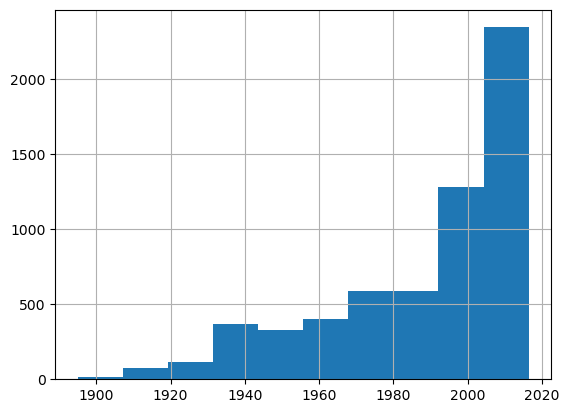

In [16]:
print(f'{lost_movies.release.isna().sum() / len(lost_movies) * 100 :.2f}% of the release dates are not available.')
lost_movies.release.hist();

99.09% of the Box Office revenues are not available.


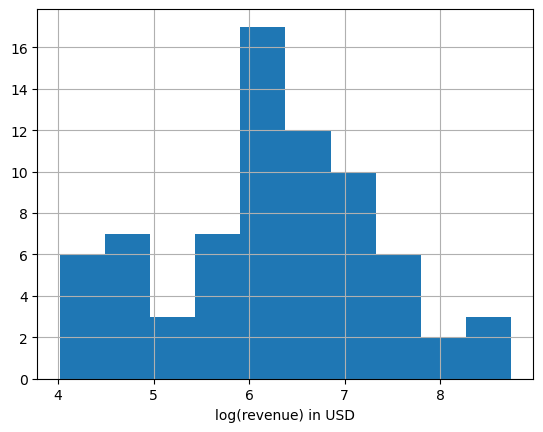

In [17]:
print(f'{lost_movies.borevenue.isna().sum() / len(lost_movies) * 100 :.2f}% of the Box Office revenues are not available.')
ax = lost_movies.borevenue.apply(np.log10).hist();
ax.set(xlabel='log(revenue) in USD');

In [18]:
type(lost_movies.languages.iloc[0])

dict

37.25% of the movies do not have any registered languages.


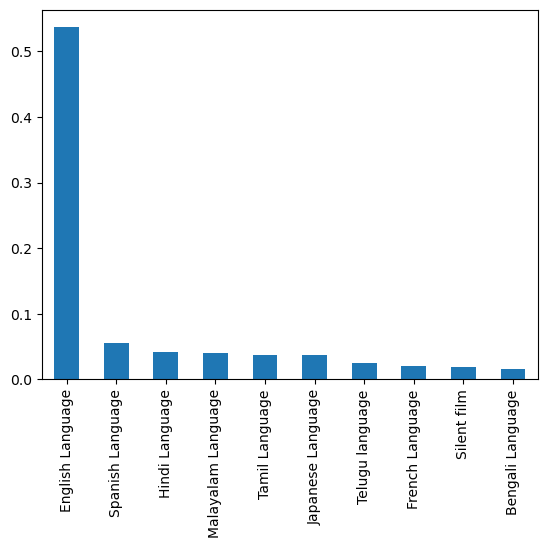

In [19]:
print(f'{100 - lost_movies.languages.apply(bool).sum() / len(lost_movies) * 100 :.2f}% of the movies do not have any registered languages.')
languages = [l for ls in lost_movies.languages for l in ls.values()]
languages = pd.Series(languages).value_counts()
languages[:10].apply(lambda x: x / languages.sum()).plot(kind='bar');

29.19% of the movies do not have any registered languages.


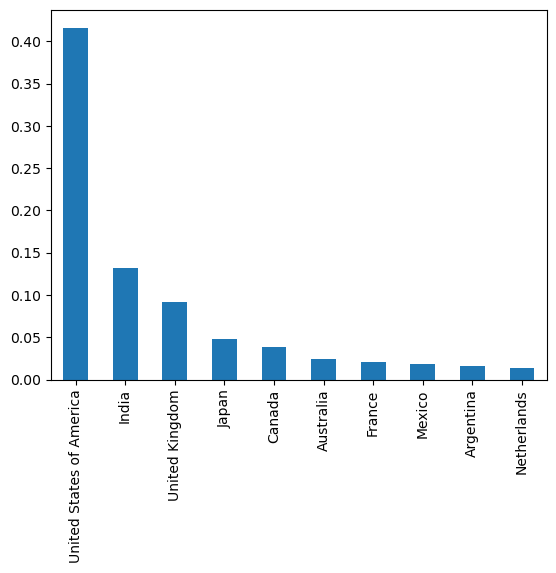

In [20]:
print(f'{100 - lost_movies.countries.apply(bool).sum() / len(lost_movies) * 100 :.2f}% of the movies do not have any registered languages.')
countries = [l for ls in lost_movies.countries for l in ls.values()]
countries = pd.Series(countries).value_counts()
countries[:10].apply(lambda x: x / countries.sum()).plot(kind='bar');